In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = ""  
db_port = "" 
db_name = ""
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [3]:
ace = '08|037|025|000|000' # Dozza

In [4]:
query= text(""" SELECT 
  date,
  SUM(ingressi) AS ingressi,
  SUM(uscite) AS uscite 
FROM ( 
  SELECT
    datefrom AS date,
    datavalue AS ingressi,
    0 AS uscite
  FROM movements
  WHERE toid LIKE '""" + ace + """'

  UNION ALL

  SELECT
    datefrom AS date,
    0 AS ingressi,
    datavalue AS uscite
  FROM movements
   WHERE layerid LIKE '""" + ace + """'
) AS movimenti
GROUP BY date
ORDER BY date; 
""")

try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True)  
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

                    date  ingressi  uscite
0    2019-08-01 00:00:00       194     246
1    2019-08-01 01:00:00        64      51
2    2019-08-01 02:00:00        71      70
3    2019-08-01 03:00:00        52      98
4    2019-08-01 04:00:00        76     128
...                  ...       ...     ...
1459 2019-09-30 19:00:00       574     426
1460 2019-09-30 20:00:00       231     398
1461 2019-09-30 21:00:00       321     248
1462 2019-09-30 22:00:00       168     103
1463 2019-09-30 23:00:00        53      36

[1464 rows x 3 columns]


In [5]:
#togliamo righe dove sono presenti 0 e calcoliamo flusso
df = df[(df['ingressi'] != 0) & (df['uscite'] != 0)]
df['flusso'] = df['ingressi'] - df['uscite']
df

,date,ingressi,uscite,flusso
0,2019-08-01 00:00:00,194,246,-52
1,2019-08-01 01:00:00,64,51,13
2,2019-08-01 02:00:00,71,70,1
3,2019-08-01 03:00:00,52,98,-46
4,2019-08-01 04:00:00,76,128,-52
...,...,...,...,...
1459,2019-09-30 19:00:00,574,426,148
1460,2019-09-30 20:00:00,231,398,-167
1461,2019-09-30 21:00:00,321,248,73
1462,2019-09-30 22:00:00,168,103,65


In [6]:
mean = df['flusso'].mean()
std = df['flusso'].std()

# Calcolo z-score
df['z_score'] = (df['flusso'] - mean) / std
df

,date,ingressi,uscite,flusso,z_score
0,2019-08-01 00:00:00,194,246,-52,-0.298874
1,2019-08-01 01:00:00,64,51,13,0.123022
2,2019-08-01 02:00:00,71,70,1,0.045134
3,2019-08-01 03:00:00,52,98,-46,-0.259930
4,2019-08-01 04:00:00,76,128,-52,-0.298874
...,...,...,...,...,...
1459,2019-09-30 19:00:00,574,426,148,0.999269
1460,2019-09-30 20:00:00,231,398,-167,-1.045307
1461,2019-09-30 21:00:00,321,248,73,0.512465
1462,2019-09-30 22:00:00,168,103,65,0.460539


In [7]:
#vediamo giorni anomali
eventi = df[df['z_score'].abs() > 3]
print(eventi)

                    date  ingressi  uscite  flusso   z_score
16   2019-08-01 16:00:00       916     435     481  3.160678
104  2019-08-05 08:00:00       314     806    -492 -3.154790
133  2019-08-06 13:00:00       191     679    -488 -3.128827
157  2019-08-07 13:00:00       766     291     475  3.121734
641  2019-08-27 17:00:00       961     405     556  3.647482
978  2019-09-10 18:00:00      1087     570     517  3.394344
1001 2019-09-11 17:00:00       392    1070    -678 -4.362064
1016 2019-09-12 08:00:00       326     851    -525 -3.368984
1024 2019-09-12 16:00:00       896     378     518  3.400834
1094 2019-09-15 14:00:00       827     359     468  3.076299
1096 2019-09-15 16:00:00       354     847    -493 -3.161281
1152 2019-09-18 00:00:00       753     180     573  3.757824
1209 2019-09-20 09:00:00       705     217     488  3.206113
1304 2019-09-24 08:00:00       525    1066    -541 -3.472835
1314 2019-09-24 18:00:00       377     909    -532 -3.414419
1334 2019-09-25 14:00:00

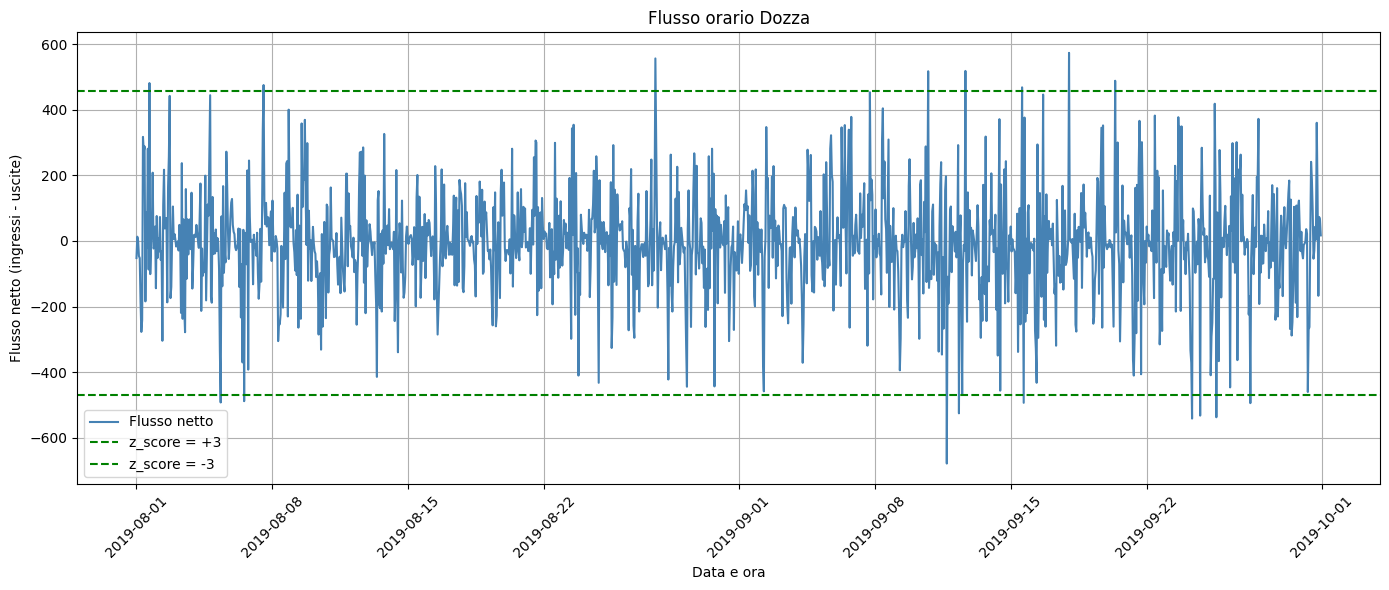

In [8]:

# Grafico del flusso con evidenza dei picchi
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['flusso'], label='Flusso netto', color='steelblue')
#plt.scatter(eventi['date'], eventi['flusso'], color='red', label='Anomalie (|z_score| > 3)', zorder=5)

# Aggiunta delle linee orizzontali per z-score (convertite in scala flusso)
media = df['flusso'].mean()
dev_std = df['flusso'].std()
soglia_pos = media + 3 * dev_std
soglia_neg = media - 3 * dev_std

plt.axhline(soglia_pos, color='green', linestyle='--', label='z_score = +3')
plt.axhline(soglia_neg, color='green', linestyle='--', label='z_score = -3')

# Finalizzazione grafico
plt.title("Flusso orario Dozza")
plt.xlabel("Data e ora")
plt.ylabel("Flusso netto (ingressi - uscite)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
